# Anomaly Detection in Dynamic (Time Series) Data
> A comprehensive exploration of methods for detecting anomalies in time-varying data

In this notebook, we'll explore various methods for detecting anomalies in time series data, from traditional statistical approaches to advanced deep learning techniques using LSTMs and autoencoders.

What you'll learn:
* Types of time series anomalies and their characteristics
* Statistical anomaly detection methods (Moving Window, ARIMA)
* Neural Network approaches (Feedforward, RNN)
* LSTM architecture with detailed gate mechanisms
* Autoencoders for unsupervised anomaly detection

By the end, you'll be able to implement and compare these approaches on real-world data.


In [1]:
# Install required packages
!pip install numpy pandas matplotlib scikit-learn tensorflow statsmodels seaborn plotly

## 1. Understanding Anomalies in Time Series

Time series anomalies come in three main types:

1. **Point Anomalies**: Individual data points that significantly deviate from the normal behavior pattern
   - Example: Sudden spike in system memory usage

2. **Contextual Anomalies**: Data points that are anomalous in a specific context but not otherwise
   - Example: 70°F temperature in winter vs. summer

3. **Collective Anomalies**: Sequences of data points that together form an anomalous pattern
   - Example: ECG readings showing arrhythmia across multiple measurements

Let's start by generating synthetic data with different types of anomalies:


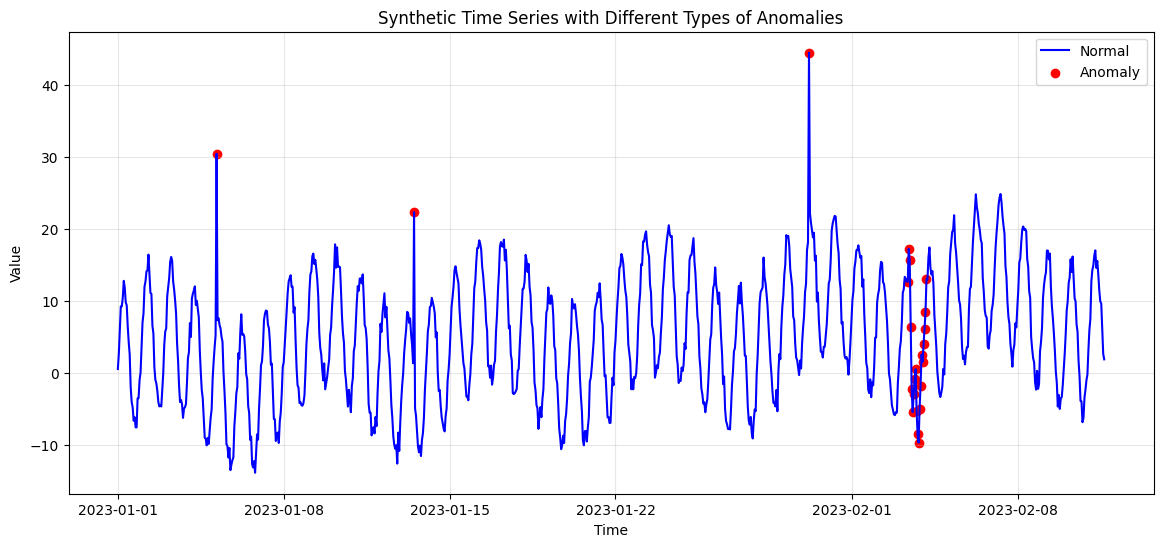

Total data points: 1000
Number of anomalies: 23
Anomaly percentage: 2.30%


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to generate synthetic time series with different anomaly types
def generate_synthetic_data(n_samples=1000):
    # Generate timestamp index
    start_date = datetime(2023, 1, 1)
    timestamps = [start_date + timedelta(hours=i) for i in range(n_samples)]

    # Generate base signal: trend + seasonality + noise
    t = np.arange(n_samples)
    trend = 0.01 * t
    daily_seasonality = 10 * np.sin(2 * np.pi * t / 24)  # 24-hour cycle
    weekly_seasonality = 5 * np.sin(2 * np.pi * t / (24 * 7))  # Weekly cycle
    noise = np.random.normal(0, 1, n_samples)

    # Combine components
    signal = trend + daily_seasonality + weekly_seasonality + noise

    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': timestamps,
        'value': signal,
        'anomaly': np.zeros(n_samples, dtype=bool)  # Initialize anomaly label
    })

    # Add point anomalies (sudden spikes)
    point_anomaly_indices = [100, 300, 700]
    for idx in point_anomaly_indices:
        df.loc[idx, 'value'] += 25  # Add large spike
        df.loc[idx, 'anomaly'] = True

    # Add contextual anomaly (unusual pattern during specific time)
    # Night hours with high values (unusual)
    contextual_start = 400
    for i in range(5):
        # Assuming night hours should have lower values
        idx = contextual_start + i
        hour = df.loc[idx, 'timestamp'].hour
        if hour >= 0 and hour <= 6:  # Night hours
            df.loc[idx, 'value'] += 15  # Unusual high value at night
            df.loc[idx, 'anomaly'] = True

    # Add collective anomaly (unusual sequence pattern)
    collective_start = 800
    for i in range(20):
        idx = collective_start + i
        # Damped oscillation pattern (different from normal seasonality)
        df.loc[idx, 'value'] += 10 * np.sin(i) * np.exp(-i/10)
        df.loc[idx, 'anomaly'] = True

    return df

# Generate data
ts_data = generate_synthetic_data()

# Visualize the time series with anomalies
plt.figure(figsize=(14, 6))
plt.plot(ts_data['timestamp'], ts_data['value'], color='blue', label='Normal')
plt.scatter(ts_data[ts_data['anomaly']]['timestamp'],
            ts_data[ts_data['anomaly']]['value'],
            color='red', label='Anomaly')
plt.title('Synthetic Time Series with Different Types of Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display summary statistics
print(f"Total data points: {len(ts_data)}")
print(f"Number of anomalies: {ts_data['anomaly'].sum()}")
print(f"Anomaly percentage: {100 * ts_data['anomaly'].sum() / len(ts_data):.2f}%")


## 2. Statistical Methods for Anomaly Detection

Statistical methods rely on mathematical principles to identify data points that significantly deviate from expected patterns. Let's explore two common approaches:

### 2.1 Moving Window Statistics
This approach uses a sliding window to calculate local statistics (mean, standard deviation) and flags points that deviate beyond a certain threshold.


Method: Moving Window
Accuracy:  0.9790
Precision: 1.0000
Recall:    0.0870
F1 Score:  0.1600
----------------------------------------


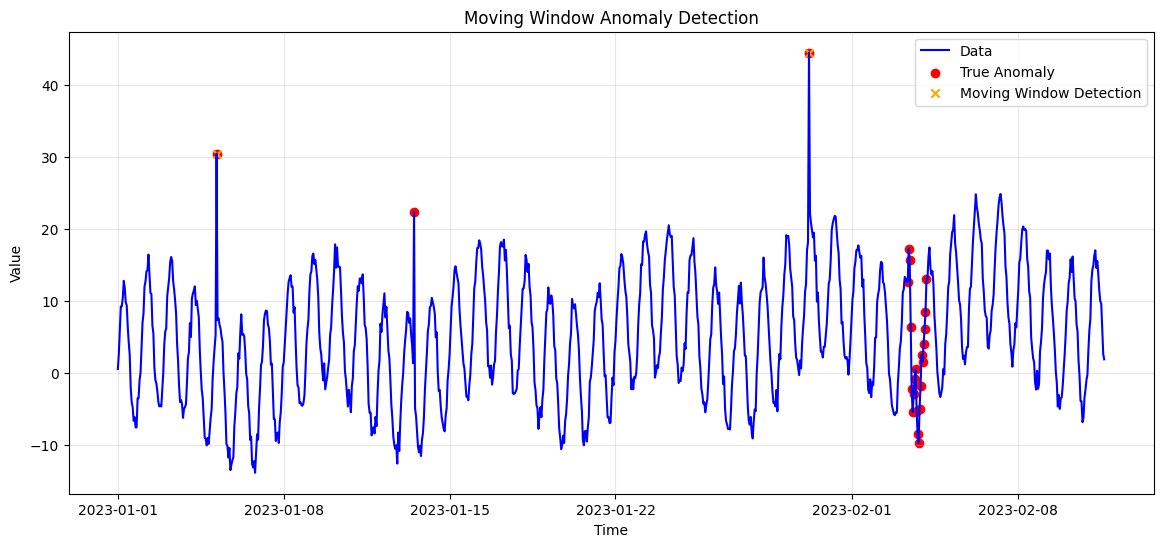

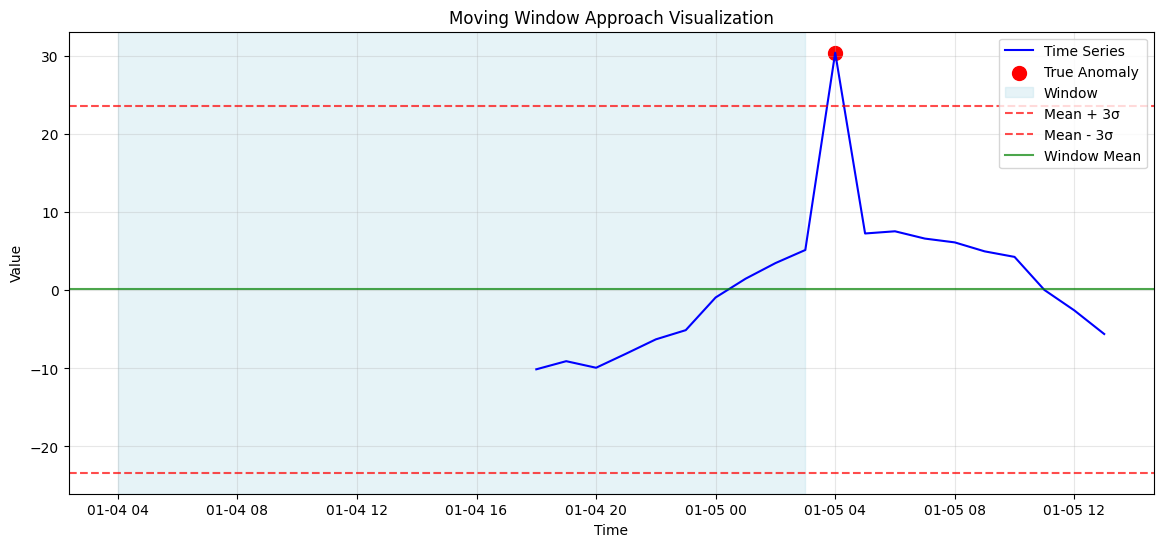

In [3]:
def moving_window_detector(series, window_size=24, n_sigmas=3):
    """
    Detect anomalies using a moving window approach.

    Parameters:
    -----------
    series: pandas.Series
        Time series data
    window_size: int
        Size of the moving window
    n_sigmas: float
        Number of standard deviations to use for thresholding

    Returns:
    --------
    pandas.Series
        Boolean series with True for detected anomalies
    """
    # Initialize results array
    anomalies = np.zeros(len(series), dtype=bool)

    # The first window_size points cannot be evaluated (not enough history)
    anomalies[:window_size] = False

    # Calculate rolling statistics
    rolling_mean = series.rolling(window=window_size).mean()
    rolling_std = series.rolling(window=window_size).std()

    # Define upper and lower thresholds
    upper_threshold = rolling_mean + n_sigmas * rolling_std
    lower_threshold = rolling_mean - n_sigmas * rolling_std

    # Flag anomalies
    anomalies[window_size:] = ((series[window_size:] > upper_threshold[window_size:]) |
                              (series[window_size:] < lower_threshold[window_size:]))

    return pd.Series(anomalies, index=series.index)

# Apply moving window detector
window_size = 24  # One day
n_sigmas = 3      # Three standard deviations
mw_anomalies = moving_window_detector(ts_data['value'], window_size, n_sigmas)

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate and display metrics
def calculate_metrics(y_true, y_pred, method_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Method: {method_name}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("-" * 40)

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Calculate metrics for moving window method
mw_metrics = calculate_metrics(ts_data['anomaly'], mw_anomalies, "Moving Window")

# Visualize results
plt.figure(figsize=(14, 6))
plt.plot(ts_data['timestamp'], ts_data['value'], color='blue', label='Data')
plt.scatter(ts_data[ts_data['anomaly']]['timestamp'],
            ts_data[ts_data['anomaly']]['value'],
            color='red', marker='o', label='True Anomaly')
plt.scatter(ts_data[mw_anomalies]['timestamp'],
            ts_data[mw_anomalies]['value'],
            color='orange', marker='x', label='Moving Window Detection')
plt.title('Moving Window Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visual explanation of the moving window approach
sample_start = 90
sample_end = 110
sample_data = ts_data.iloc[sample_start:sample_end]

plt.figure(figsize=(14, 6))

# Data points
plt.plot(sample_data['timestamp'], sample_data['value'], 'b-', label='Time Series')
plt.scatter(sample_data[sample_data['anomaly']]['timestamp'],
            sample_data[sample_data['anomaly']]['value'],
            color='red', s=100, label='True Anomaly')

# For a specific point, show the window used to calculate statistics
point_idx = 100
window_data = ts_data.iloc[point_idx-window_size:point_idx]
window_mean = window_data['value'].mean()
window_std = window_data['value'].std()

# Shade the window area
plt.axvspan(window_data['timestamp'].iloc[0], window_data['timestamp'].iloc[-1],
           color='lightblue', alpha=0.3, label='Window')

# Show thresholds
plt.axhline(y=window_mean + n_sigmas*window_std, color='red', linestyle='--', alpha=0.7,
           label=f'Mean + {n_sigmas}σ')
plt.axhline(y=window_mean - n_sigmas*window_std, color='red', linestyle='--', alpha=0.7,
           label=f'Mean - {n_sigmas}σ')
plt.axhline(y=window_mean, color='green', linestyle='-', alpha=0.7, label='Window Mean')

plt.title('Moving Window Approach Visualization')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 2.2 ARIMA-based Anomaly Detection

AutoRegressive Integrated Moving Average (ARIMA) models are classical time series forecasting models that can be used for anomaly detection. The approach is:

1. Fit an ARIMA model to the time series
2. Use the model to forecast values
3. Compare actual values with forecasted values
4. Flag significant deviations as anomalies

ARIMA models have three components:
- **AR(p)**: AutoRegressive term - uses the relationship between an observation and p lagged observations
- **I(d)**: Integrated - differencing to make the data stationary  
- **MA(q)**: Moving Average term - uses the dependency between an observation and a residual error from a moving average model applied to q lagged observations


Method: ARIMA
Accuracy:  0.8960
Precision: 0.1478
Recall:    0.7391
F1 Score:  0.2464
----------------------------------------


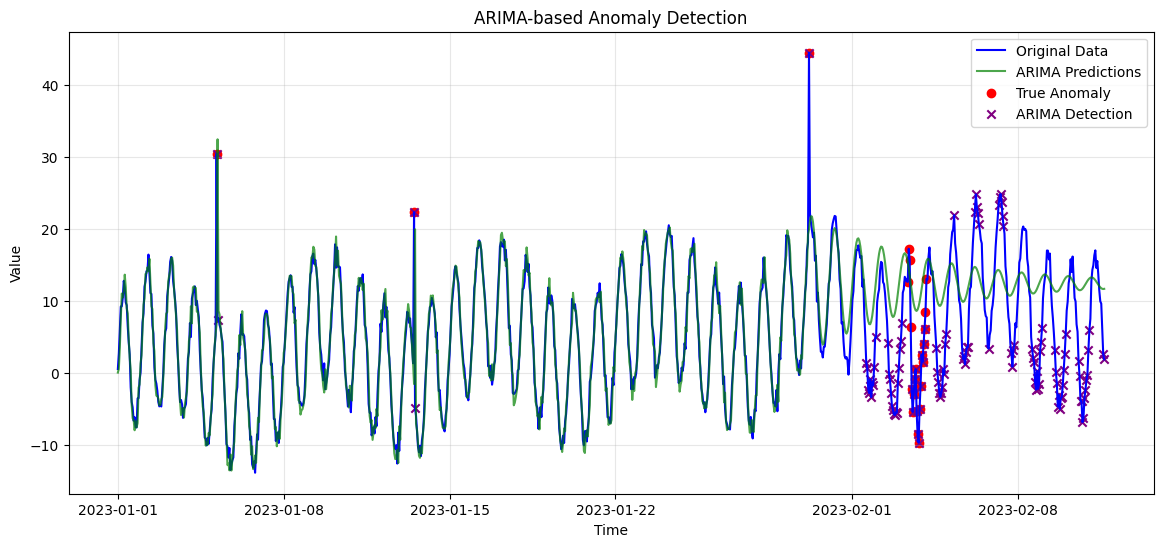

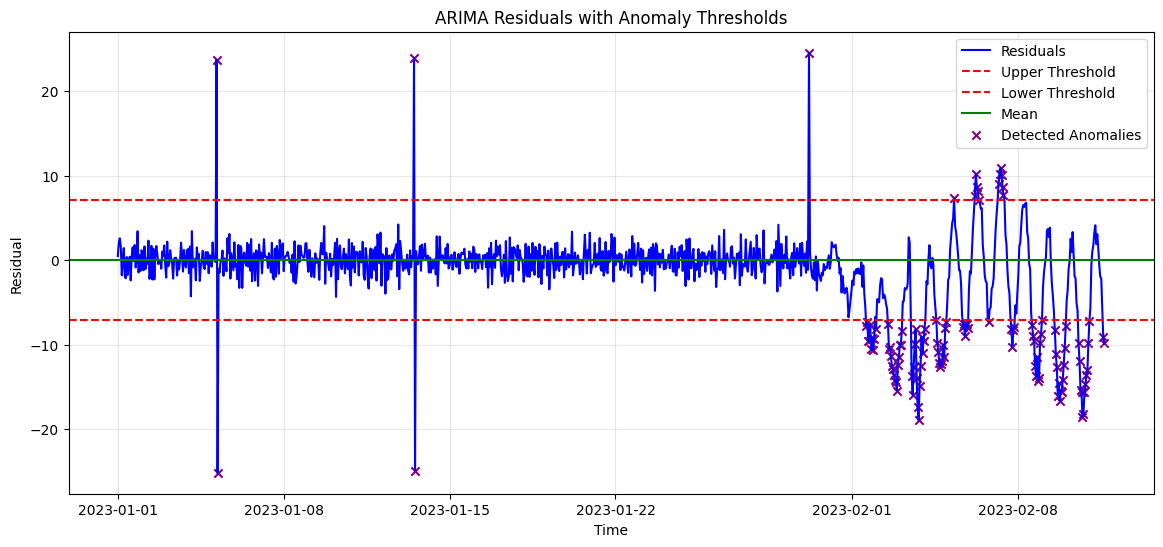

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')  # Suppress convergence warnings

def arima_detector(series, order=(1,1,1), n_sigmas=3, train_size=0.7):
    """
    Detect anomalies using an ARIMA model.

    Parameters:
    -----------
    series: pandas.Series
        Time series data
    order: tuple
        ARIMA model order (p,d,q)
    n_sigmas: float
        Number of standard deviations to use for thresholding
    train_size: float
        Proportion of data to use for training

    Returns:
    --------
    pandas.Series
        Boolean series with True for detected anomalies
    """
    # Split data into training and testing
    train_size_idx = int(len(series) * train_size)
    train = series[:train_size_idx]
    test = series[train_size_idx:]

    # Fit ARIMA model on training data
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Make predictions on the entire dataset
    predictions = model_fit.predict(start=0, end=len(series)-1)

    # Calculate residuals (errors)
    residuals = series - predictions

    # Calculate threshold based on residual statistics
    residual_mean = residuals[:train_size_idx].mean()
    residual_std = residuals[:train_size_idx].std()

    # Define anomaly thresholds
    upper_threshold = residual_mean + n_sigmas * residual_std
    lower_threshold = residual_mean - n_sigmas * residual_std

    # Flag anomalies
    anomalies = (residuals > upper_threshold) | (residuals < lower_threshold)

    return anomalies, predictions

# Apply ARIMA-based detector
arima_order = (2, 1, 2)  # p, d, q
arima_anomalies, arima_predictions = arima_detector(ts_data['value'], order=arima_order)

# Calculate metrics for ARIMA method
arima_metrics = calculate_metrics(ts_data['anomaly'], arima_anomalies, "ARIMA")

# Visualize ARIMA results
plt.figure(figsize=(14, 6))
plt.plot(ts_data['timestamp'], ts_data['value'], color='blue', label='Original Data')
plt.plot(ts_data['timestamp'], arima_predictions, color='green', alpha=0.7, label='ARIMA Predictions')
plt.scatter(ts_data[ts_data['anomaly']]['timestamp'],
            ts_data[ts_data['anomaly']]['value'],
            color='red', marker='o', label='True Anomaly')
plt.scatter(ts_data[arima_anomalies]['timestamp'],
            ts_data[arima_anomalies]['value'],
            color='purple', marker='x', label='ARIMA Detection')
plt.title('ARIMA-based Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize residuals and thresholds
residuals = ts_data['value'] - arima_predictions
train_size_idx = int(len(ts_data) * 0.7)
residual_mean = residuals[:train_size_idx].mean()
residual_std = residuals[:train_size_idx].std()
upper_threshold = residual_mean + 3 * residual_std
lower_threshold = residual_mean - 3 * residual_std

plt.figure(figsize=(14, 6))
plt.plot(ts_data['timestamp'], residuals, color='blue', label='Residuals')
plt.axhline(y=upper_threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(y=lower_threshold, color='red', linestyle='--', label='Lower Threshold')
plt.axhline(y=residual_mean, color='green', linestyle='-', label='Mean')
plt.scatter(ts_data[arima_anomalies]['timestamp'],
            residuals[arima_anomalies],
            color='purple', marker='x', label='Detected Anomalies')
plt.title('ARIMA Residuals with Anomaly Thresholds')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 3. Neural Network Approaches for Anomaly Detection

Neural networks provide powerful tools for anomaly detection due to their ability to learn complex patterns. Let's explore their application to time series data.

### 3.1 Feedforward Neural Networks

Feedforward Neural Networks (FFNNs) can be adapted for time series by using a sliding window approach to create input-output pairs from sequential data.


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1191 - val_loss: 0.0113
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - val_loss: 0.0101
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0062
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0077
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0082
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0078
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0074
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0062
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

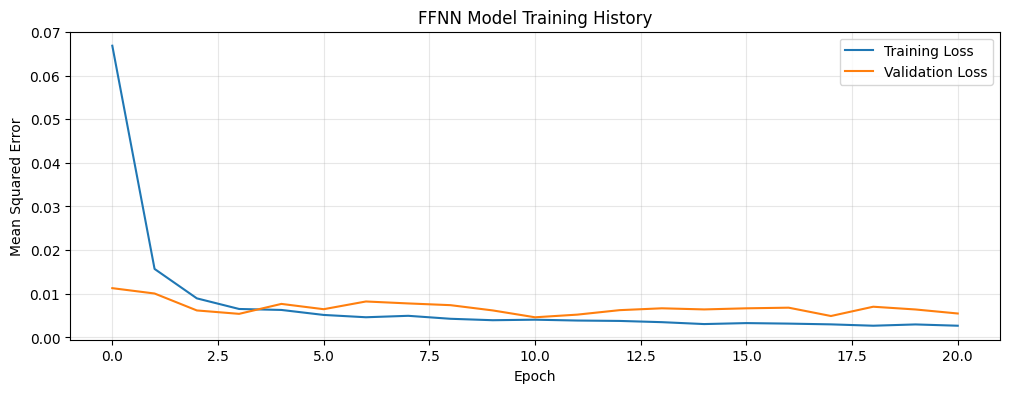

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Method: Feedforward Neural Network
Accuracy:  0.9795
Precision: 1.0000
Recall:    0.1304
F1 Score:  0.2308
----------------------------------------


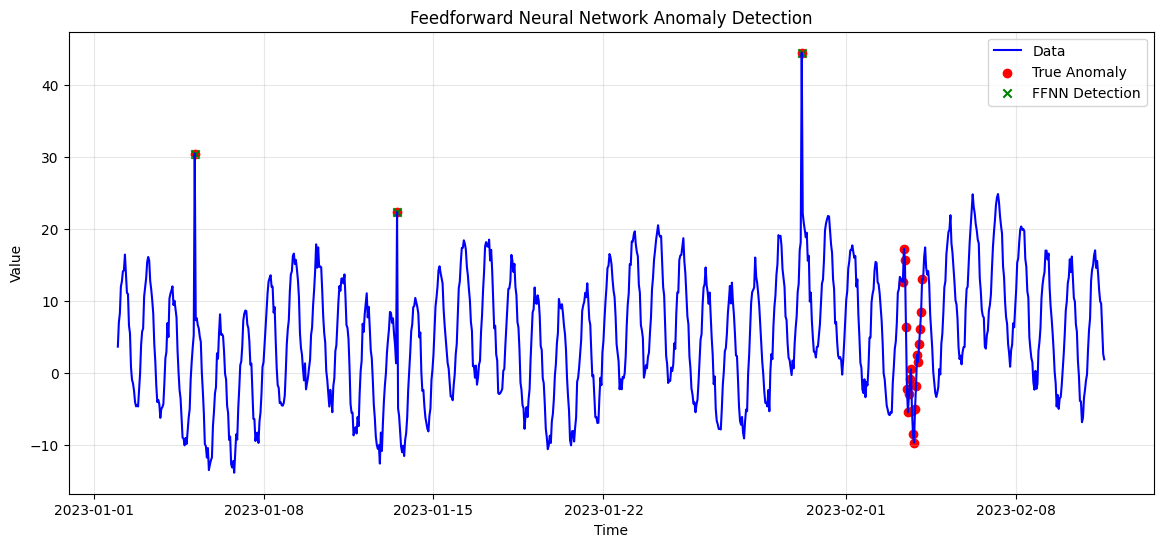

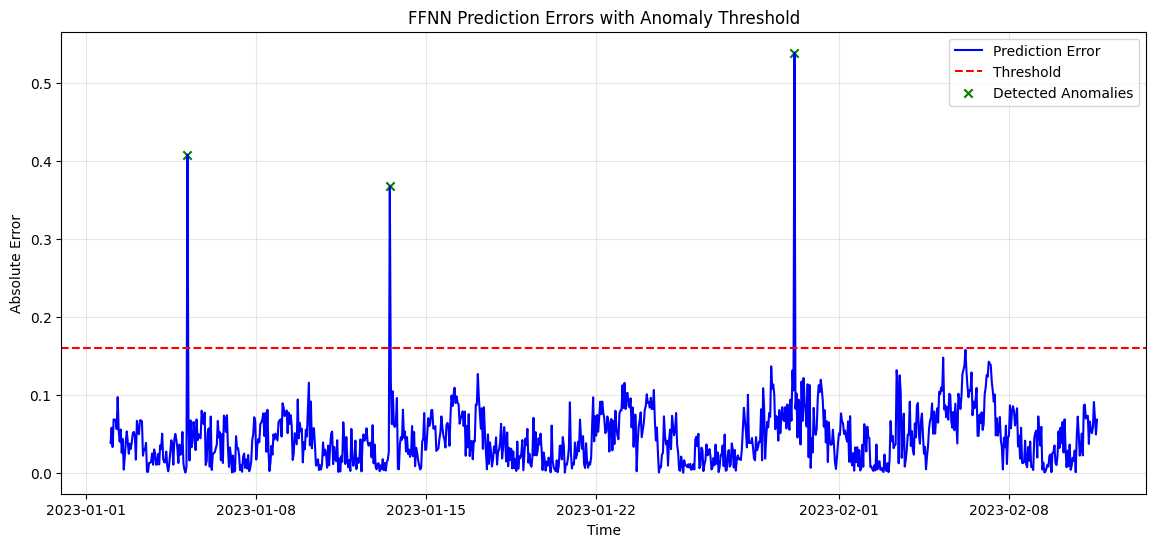

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_sequences(data, seq_length):
    """
    Create input-output pairs from sequential data.

    Parameters:
    -----------
    data: numpy.ndarray
        Input time series data
    seq_length: int
        Length of input sequence (window size)

    Returns:
    --------
    X: numpy.ndarray
        Input sequences
    y: numpy.ndarray
        Target values (next point after each sequence)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(ts_data['value'].values.reshape(-1, 1)).flatten()

# Create sequences
seq_length = 24  # Use 24-hour window to capture daily patterns
X, y = create_sequences(data_scaled, seq_length)

# Split into train/test sets ensuring no anomalies in training
train_indices = np.where(ts_data['anomaly'][seq_length:] == False)[0]
test_indices = np.arange(len(X))
test_indices = np.setdiff1d(test_indices, train_indices)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Build feedforward neural network
ffnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(seq_length,)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

ffnn_model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

# Train model
history = ffnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('FFNN Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Use model for anomaly detection
def ffnn_detector(model, X, y, threshold_multiplier=3):
    """
    Detect anomalies using prediction errors from a neural network.

    Parameters:
    -----------
    model: tensorflow.keras.Model
        Trained neural network model
    X: numpy.ndarray
        Input sequences
    y: numpy.ndarray
        Actual target values
    threshold_multiplier: float
        Multiplier for standard deviation to set threshold

    Returns:
    --------
    numpy.ndarray
        Boolean array with True for anomalies
    """
    # Make predictions
    y_pred = model.predict(X)

    # Calculate errors
    errors = np.abs(y - y_pred.flatten())

    # Set threshold based on error statistics
    threshold = np.mean(errors) + threshold_multiplier * np.std(errors)

    # Detect anomalies
    anomalies = errors > threshold

    return anomalies, errors, threshold

# Apply FFNN detector to entire dataset
X_all, y_all = create_sequences(data_scaled, seq_length)
ffnn_anomalies, ffnn_errors, ffnn_threshold = ffnn_detector(ffnn_model, X_all, y_all)

# Map back to original time points
ts_data_ffnn = ts_data.iloc[seq_length:].copy()
ts_data_ffnn['ffnn_anomaly'] = ffnn_anomalies
ts_data_ffnn['ffnn_error'] = ffnn_errors

# Calculate metrics for FFNN method
ffnn_metrics = calculate_metrics(ts_data_ffnn['anomaly'], ts_data_ffnn['ffnn_anomaly'], "Feedforward Neural Network")

# Visualize FFNN results
plt.figure(figsize=(14, 6))
plt.plot(ts_data_ffnn['timestamp'], ts_data_ffnn['value'], color='blue', label='Data')
plt.scatter(ts_data_ffnn[ts_data_ffnn['anomaly']]['timestamp'],
            ts_data_ffnn[ts_data_ffnn['anomaly']]['value'],
            color='red', marker='o', label='True Anomaly')
plt.scatter(ts_data_ffnn[ts_data_ffnn['ffnn_anomaly']]['timestamp'],
            ts_data_ffnn[ts_data_ffnn['ffnn_anomaly']]['value'],
            color='green', marker='x', label='FFNN Detection')
plt.title('Feedforward Neural Network Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize prediction errors
plt.figure(figsize=(14, 6))
plt.plot(ts_data_ffnn['timestamp'], ffnn_errors, color='blue', label='Prediction Error')
plt.axhline(y=ffnn_threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(ts_data_ffnn[ts_data_ffnn['ffnn_anomaly']]['timestamp'],
            ts_data_ffnn[ts_data_ffnn['ffnn_anomaly']]['ffnn_error'],
            color='green', marker='x', label='Detected Anomalies')
plt.title('FFNN Prediction Errors with Anomaly Threshold')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 3.2 Recurrent Neural Networks (RNNs)

RNNs are designed specifically for sequential data, with connections that form cycles allowing information to persist. However, basic RNNs suffer from the vanishing gradient problem, which limits their ability to learn long-term dependencies.

#### Vanishing Gradient Problem

The vanishing gradient problem occurs when gradients are repeatedly multiplied through many time steps during backpropagation. Since these gradients are typically small (< 1), they tend to vanish exponentially, preventing the network from learning long-term dependencies.

Mathematically, for a simple RNN, the gradient calculation involves a product chain:

$$\frac{\partial L}{\partial W} \propto \prod_{i=1}^{n} \frac{\partial h_i}{\partial h_{i-1}}$$

For activation functions like tanh, the derivative is ≤ 0.25 at all points. After n steps, the gradient becomes ≤ 0.25^n, which approaches zero quickly for large n.


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0386 - val_loss: 0.0060
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 9.5374e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.9783e-04 - val_loss: 0.0011
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6257e-04 - val_loss: 0.0011
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

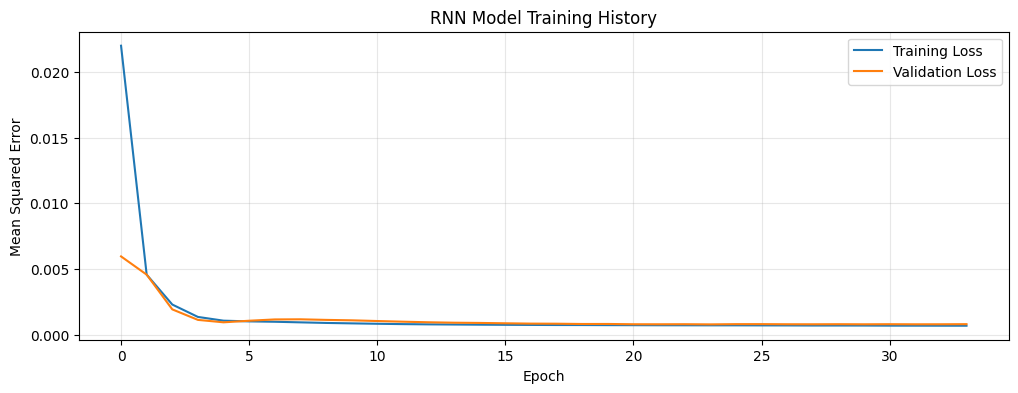

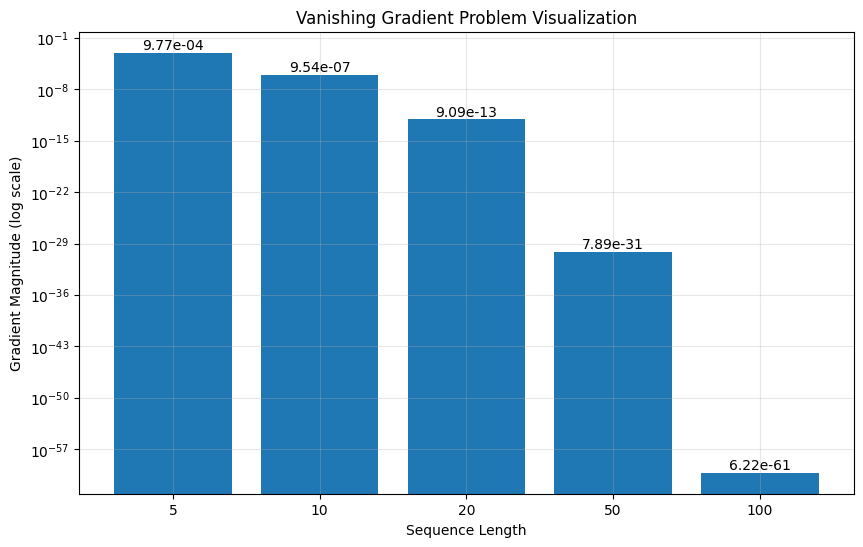

In [6]:
from tensorflow.keras.layers import SimpleRNN

# Build a simple RNN model
rnn_model = Sequential([
    SimpleRNN(32, activation='tanh', input_shape=(seq_length, 1), return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse')

# Reshape input for RNN (samples, time steps, features)
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the model
history_rnn = rnn_model.fit(
    X_train_rnn, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Visualize RNN training
plt.figure(figsize=(12, 4))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Demonstrate vanishing gradient with a custom visualization
def visualize_vanishing_gradient():
    # Create a simple chain of multiplication to simulate backpropagation
    chain_lengths = [5, 10, 20, 50, 100]
    gradients = []

    for length in chain_lengths:
        # Simulating tanh derivative (max value 0.25) multiplied through the chain
        gradient = np.power(0.25, length)
        gradients.append(gradient)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(chain_lengths)), gradients, tick_label=[str(l) for l in chain_lengths])
    plt.yscale('log')  # Log scale to better visualize small values
    plt.title('Vanishing Gradient Problem Visualization')
    plt.xlabel('Sequence Length')
    plt.ylabel('Gradient Magnitude (log scale)')
    plt.grid(True, alpha=0.3)

    # Add value annotations
    for i, v in enumerate(gradients):
        plt.text(i, v, f'{v:.2e}', ha='center', va='bottom')

    plt.show()

visualize_vanishing_gradient()


### 3.3 Long Short-Term Memory (LSTM)

LSTM networks are specifically designed to address the vanishing gradient problem by introducing a cell state and three specialized gates that control information flow.

#### LSTM Architecture

1. **Forget Gate**: Controls what information to discard from the cell state
   - $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$

2. **Input Gate**: Controls what new information to add to the cell state
   - $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
   - $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$ (candidate values)
   - Cell state update: $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$

3. **Output Gate**: Controls what information to output
   - $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$
   - Hidden state: $h_t = o_t * \tanh(C_t)$

This architecture allows LSTMs to learn long-term dependencies much more effectively than standard RNNs.


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0781 - val_loss: 0.0160
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0153 - val_loss: 0.0129
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012 - val_loss: 6.8304e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0010 - val_loss: 6.1952e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.4553e-04 - val_loss: 6.3789e-04
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/

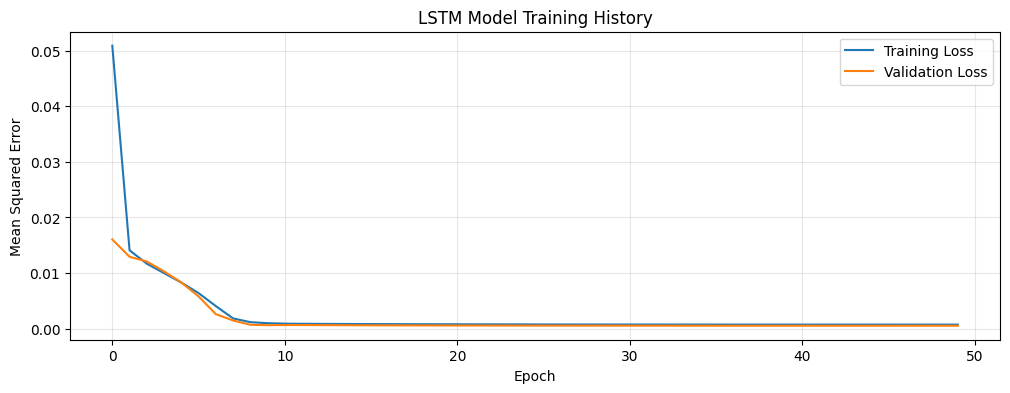

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Method: LSTM
Accuracy:  0.9805
Precision: 0.7000
Recall:    0.3043
F1 Score:  0.4242
----------------------------------------


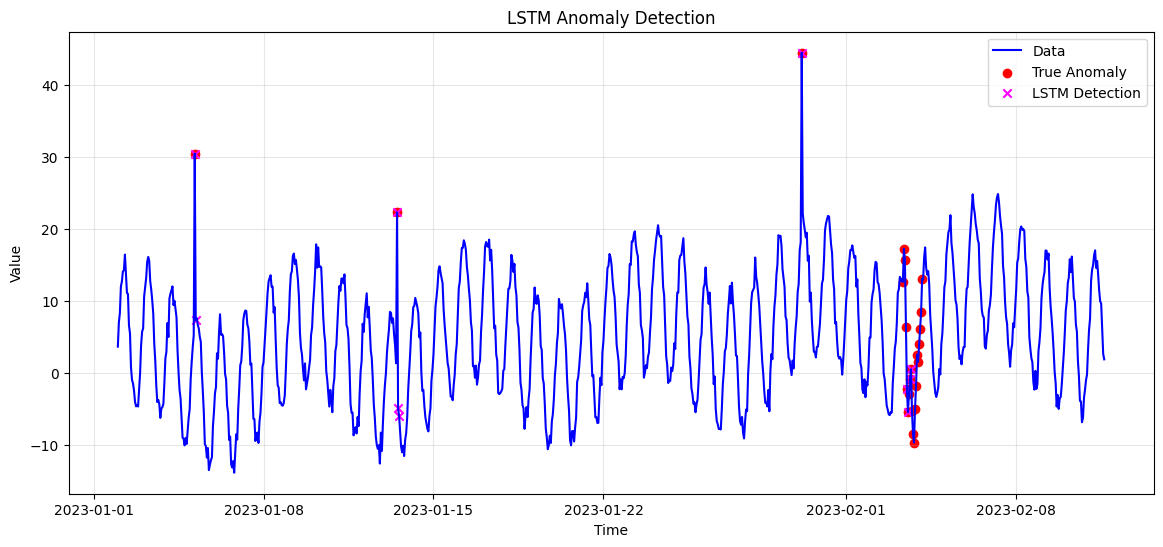

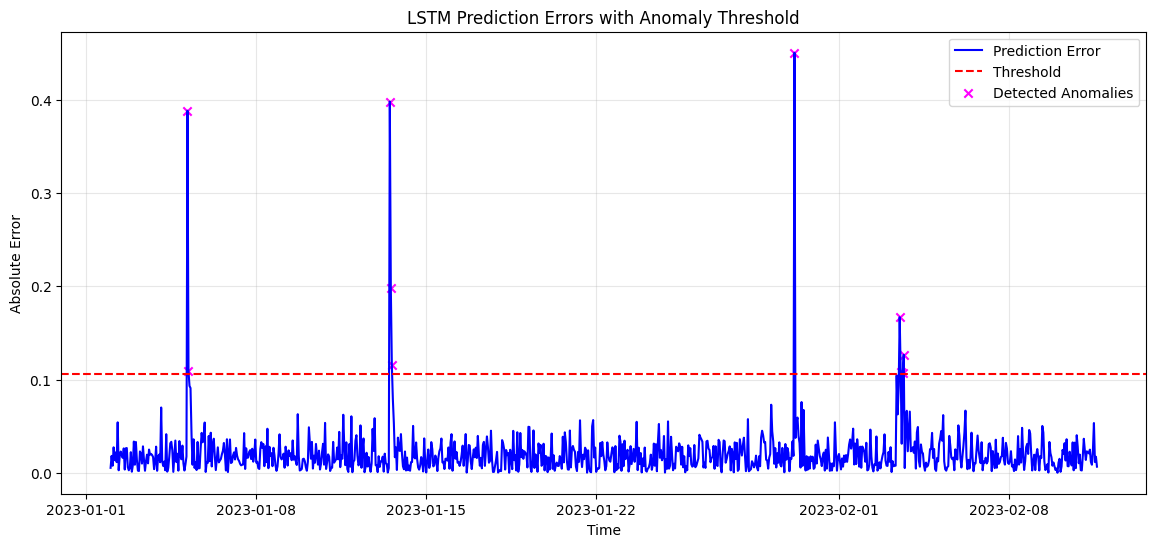

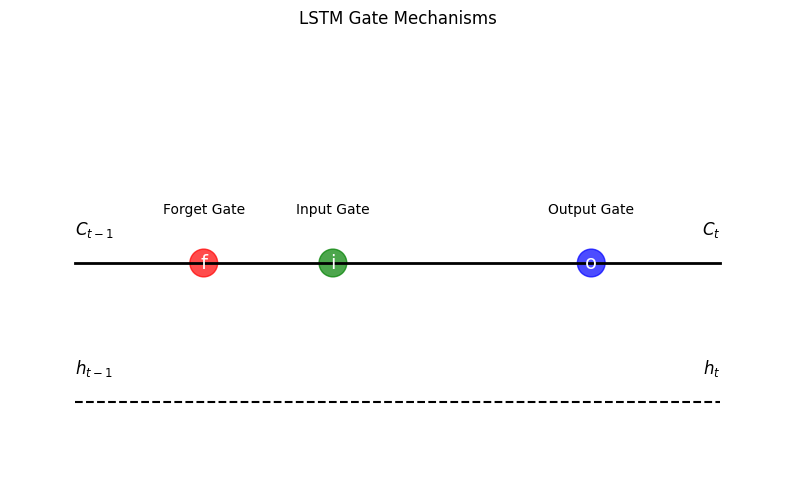

In [7]:
from tensorflow.keras.layers import LSTM

# Build LSTM model
lstm_model = Sequential([
    LSTM(32, activation='tanh', input_shape=(seq_length, 1), return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
history_lstm = lstm_model.fit(
    X_train_rnn,  # Reuse the RNN-formatted input
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot LSTM training history
plt.figure(figsize=(12, 4))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# LSTM Anomaly Detection
X_all_lstm = X_all.reshape(X_all.shape[0], X_all.shape[1], 1)
y_pred_lstm = lstm_model.predict(X_all_lstm).flatten()
lstm_errors = np.abs(y_all - y_pred_lstm)
lstm_threshold = np.mean(lstm_errors) + 3 * np.std(lstm_errors)
lstm_anomalies = lstm_errors > lstm_threshold

# Map back to original time points
ts_data_lstm = ts_data.iloc[seq_length:].copy()
ts_data_lstm['lstm_anomaly'] = lstm_anomalies
ts_data_lstm['lstm_error'] = lstm_errors

# Calculate metrics for LSTM method
lstm_metrics = calculate_metrics(ts_data_lstm['anomaly'], ts_data_lstm['lstm_anomaly'], "LSTM")

# Visualize LSTM results
plt.figure(figsize=(14, 6))
plt.plot(ts_data_lstm['timestamp'], ts_data_lstm['value'], color='blue', label='Data')
plt.scatter(ts_data_lstm[ts_data_lstm['anomaly']]['timestamp'],
            ts_data_lstm[ts_data_lstm['anomaly']]['value'],
            color='red', marker='o', label='True Anomaly')
plt.scatter(ts_data_lstm[ts_data_lstm['lstm_anomaly']]['timestamp'],
            ts_data_lstm[ts_data_lstm['lstm_anomaly']]['value'],
            color='magenta', marker='x', label='LSTM Detection')
plt.title('LSTM Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize LSTM errors
plt.figure(figsize=(14, 6))
plt.plot(ts_data_lstm['timestamp'], lstm_errors, color='blue', label='Prediction Error')
plt.axhline(y=lstm_threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(ts_data_lstm[ts_data_lstm['lstm_anomaly']]['timestamp'],
            ts_data_lstm[ts_data_lstm['lstm_anomaly']]['lstm_error'],
            color='magenta', marker='x', label='Detected Anomalies')
plt.title('LSTM Prediction Errors with Anomaly Threshold')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize the LSTM architecture with gate mechanisms
def visualize_lstm_gates():
    plt.figure(figsize=(10, 6))

    # Create a diagram-like visualization
    plt.plot([0, 1], [0.5, 0.5], 'k-', linewidth=2)  # Cell state line
    plt.plot([0, 1], [0.2, 0.2], 'k--')  # Hidden state line

    # Gates
    plt.scatter([0.2, 0.4, 0.8], [0.5, 0.5, 0.5], s=400, color=['red', 'green', 'blue'], alpha=0.7)
    plt.text(0.2, 0.5, 'f', color='white', ha='center', va='center', fontsize=14)
    plt.text(0.4, 0.5, 'i', color='white', ha='center', va='center', fontsize=14)
    plt.text(0.8, 0.5, 'o', color='white', ha='center', va='center', fontsize=14)

    # Labels
    plt.text(0, 0.55, '$C_{t-1}$', ha='left', va='bottom', fontsize=12)
    plt.text(1, 0.55, '$C_t$', ha='right', va='bottom', fontsize=12)
    plt.text(0, 0.25, '$h_{t-1}$', ha='left', va='bottom', fontsize=12)
    plt.text(1, 0.25, '$h_t$', ha='right', va='bottom', fontsize=12)
    plt.text(0.2, 0.6, 'Forget Gate', ha='center', va='bottom')
    plt.text(0.4, 0.6, 'Input Gate', ha='center', va='bottom')
    plt.text(0.8, 0.6, 'Output Gate', ha='center', va='bottom')

    plt.title('LSTM Gate Mechanisms')
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.show()

visualize_lstm_gates()


## 4. LSTM Autoencoders for Anomaly Detection

Autoencoders are a type of neural network that learn to reconstruct their input. By training an autoencoder on normal data, it learns to reconstruct normal patterns well. When fed with anomalous data, the reconstruction error increases, providing a natural anomaly score.

LSTM Autoencoders combine the sequence-handling capabilities of LSTMs with the unsupervised learning approach of autoencoders, making them particularly well-suited for time series anomaly detection.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,905 (62.13 KB)

 Trainable params: 15,905 (62.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0983 - val_loss: 0.0498
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0305 - val_loss: 0.0422
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0263 - val_loss: 0.0343
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0236 - val_loss: 0.0299
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0213 - val_loss: 0.0250
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0188 - val_loss: 0.0207
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0112 - val_loss: 0.0154
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0104 - val_loss: 0.0117
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0094 - val_loss: 0.0104
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.

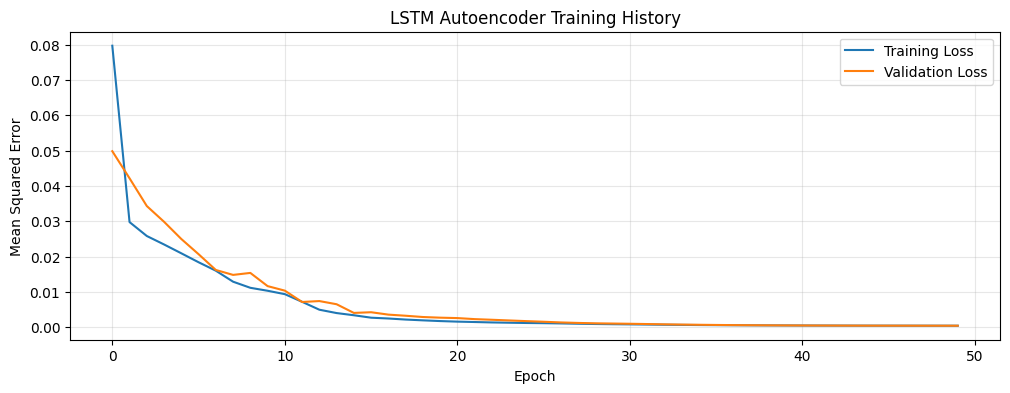

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Reconstruction error threshold: 0.001017
Method: LSTM Autoencoder
Accuracy:  0.6800
Precision: 0.0671
Recall:    1.0000
F1 Score:  0.1257
----------------------------------------


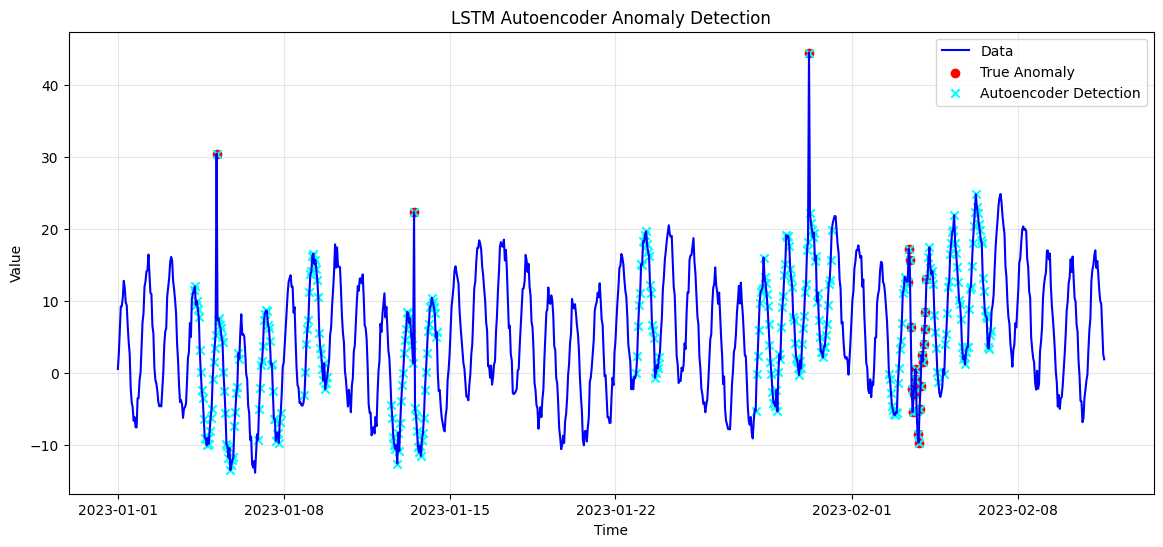

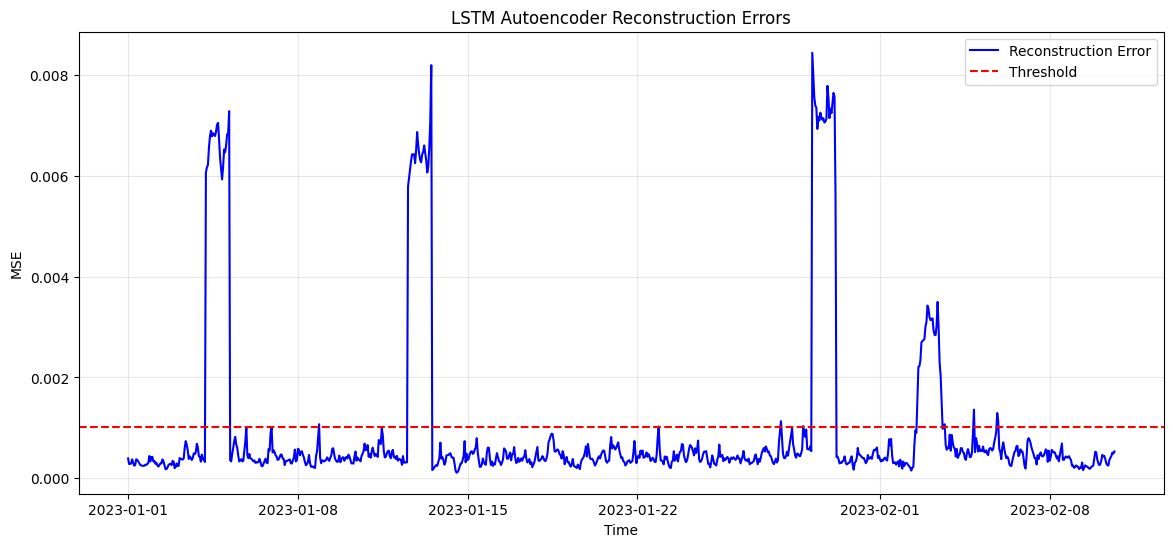

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


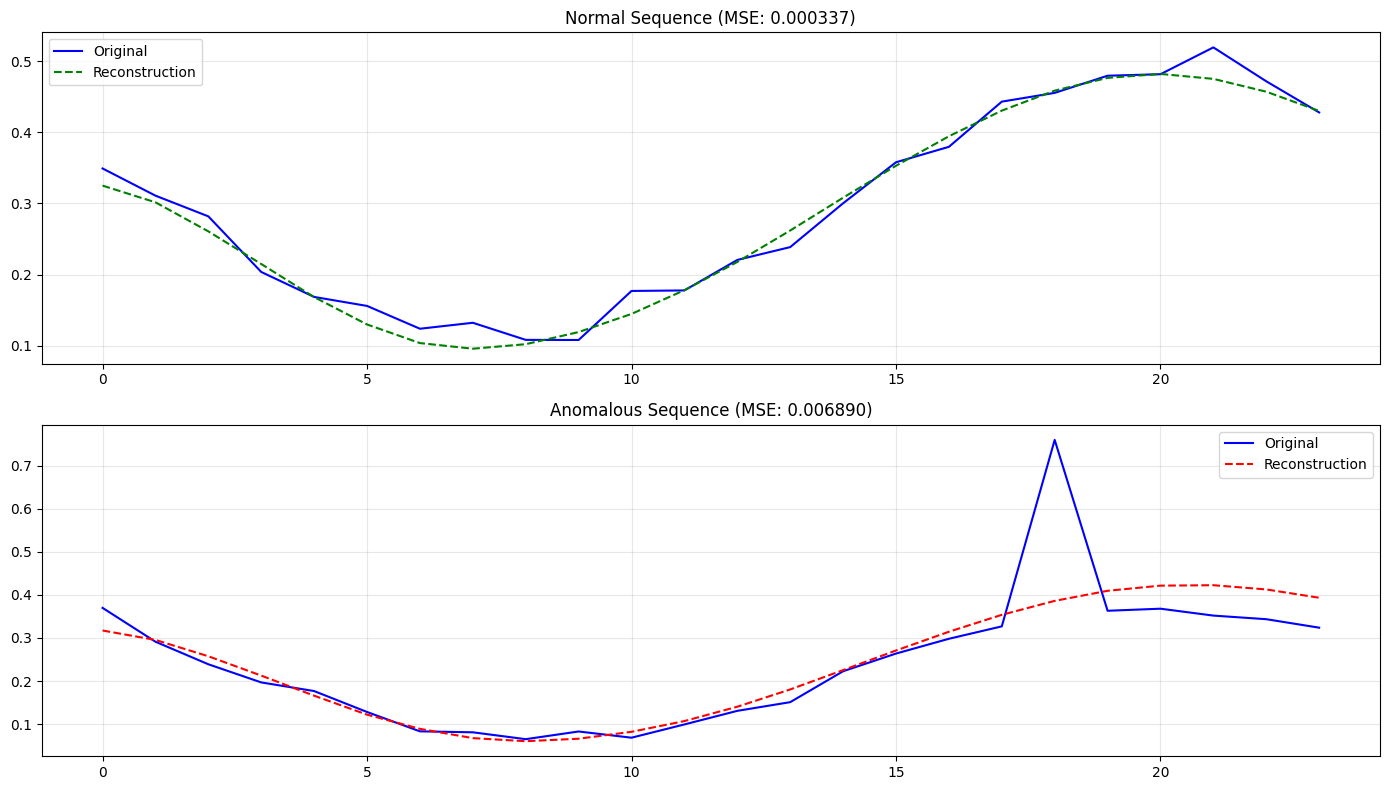

In [8]:
from tensorflow.keras.layers import RepeatVector, TimeDistributed

# Build LSTM Autoencoder model
def build_lstm_autoencoder(seq_length, features=1):
    model = Sequential([
        # Encoder
        LSTM(32, activation='relu', input_shape=(seq_length, features), return_sequences=True),
        LSTM(16, activation='relu', return_sequences=False),

        # Bottleneck
        RepeatVector(seq_length),  # Repeat the encoded representation for decoder

        # Decoder
        LSTM(16, activation='relu', return_sequences=True),
        LSTM(32, activation='relu', return_sequences=True),

        # Output layer
        TimeDistributed(Dense(features))  # Output for each time step
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create sequences for autoencoder (input = output)
def create_autoencoder_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

# Prepare data for autoencoder
autoencoder_sequences = create_autoencoder_sequences(data_scaled, seq_length)
autoencoder_sequences_reshaped = autoencoder_sequences.reshape(-1, seq_length, 1)

# Split into normal and anomaly sequences
normal_indices = []
anomaly_indices = []

for i in range(len(autoencoder_sequences)):
    # Check if there are any anomalies in this sequence
    if np.any(ts_data['anomaly'][i:i+seq_length]):
        anomaly_indices.append(i)
    else:
        normal_indices.append(i)

# Get normal data for training
normal_sequences = autoencoder_sequences_reshaped[normal_indices]

# Split into train and validation
train_val_split = int(len(normal_sequences) * 0.8)
train_sequences = normal_sequences[:train_val_split]
val_sequences = normal_sequences[train_val_split:]

# Build and train autoencoder
lstm_autoencoder = build_lstm_autoencoder(seq_length)
lstm_autoencoder.summary()

# Train the autoencoder on normal data only
history_autoencoder = lstm_autoencoder.fit(
    train_sequences, train_sequences,  # Input = output for autoencoder
    epochs=50,
    batch_size=32,
    validation_data=(val_sequences, val_sequences),
    callbacks=[early_stopping],
    verbose=1
)

# Plot autoencoder training history
plt.figure(figsize=(12, 4))
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate reconstruction errors
def calculate_reconstruction_error(model, data):
    """Calculate sequence reconstruction error."""
    reconstructions = model.predict(data)
    # MSE for each sequence
    mse = np.mean(np.square(data - reconstructions), axis=(1, 2))
    return mse

# Get reconstruction errors
train_errors = calculate_reconstruction_error(lstm_autoencoder, train_sequences)
val_errors = calculate_reconstruction_error(lstm_autoencoder, val_sequences)
all_errors = calculate_reconstruction_error(lstm_autoencoder, autoencoder_sequences_reshaped)

# Set threshold based on validation errors
threshold = np.mean(val_errors) + 3 * np.std(val_errors)
print(f"Reconstruction error threshold: {threshold:.6f}")

# Detect anomalies
autoencoder_anomalies = all_errors > threshold

# Map back to original data
ts_data_ae = ts_data.copy()
ts_data_ae['ae_anomaly'] = False
ts_data_ae['reconstruction_error'] = np.nan

# For each sequence, if it's anomalous, mark all points in that sequence
for i in range(len(autoencoder_anomalies)):
    if autoencoder_anomalies[i]:
        ts_data_ae.loc[i:i+seq_length-1, 'ae_anomaly'] = True
    ts_data_ae.loc[i, 'reconstruction_error'] = all_errors[i]

# Calculate metrics for autoencoder method
ae_metrics = calculate_metrics(ts_data_ae['anomaly'], ts_data_ae['ae_anomaly'], "LSTM Autoencoder")

# Visualize autoencoder results
plt.figure(figsize=(14, 6))
plt.plot(ts_data_ae['timestamp'], ts_data_ae['value'], color='blue', label='Data')
plt.scatter(ts_data_ae[ts_data_ae['anomaly']]['timestamp'],
            ts_data_ae[ts_data_ae['anomaly']]['value'],
            color='red', marker='o', label='True Anomaly')
plt.scatter(ts_data_ae[ts_data_ae['ae_anomaly']]['timestamp'],
            ts_data_ae[ts_data_ae['ae_anomaly']]['value'],
            color='cyan', marker='x', label='Autoencoder Detection')
plt.title('LSTM Autoencoder Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize reconstruction errors
plt.figure(figsize=(14, 6))
plt.plot(ts_data_ae['timestamp'], ts_data_ae['reconstruction_error'], color='blue', label='Reconstruction Error')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('LSTM Autoencoder Reconstruction Errors')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare normal vs anomaly reconstructions
def visualize_reconstructions():
    # Get sample normal sequence
    normal_idx = normal_indices[10]
    normal_seq = autoencoder_sequences_reshaped[normal_idx]
    normal_recon = lstm_autoencoder.predict(normal_seq.reshape(1, seq_length, 1))[0]

    # Get sample anomaly sequence
    anomaly_idx = anomaly_indices[5]
    anomaly_seq = autoencoder_sequences_reshaped[anomaly_idx]
    anomaly_recon = lstm_autoencoder.predict(anomaly_seq.reshape(1, seq_length, 1))[0]

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Normal sequence
    axes[0].plot(normal_seq, label='Original', color='blue')
    axes[0].plot(normal_recon, label='Reconstruction', color='green', linestyle='--')
    normal_error = np.mean(np.square(normal_seq - normal_recon))
    axes[0].set_title(f'Normal Sequence (MSE: {normal_error:.6f})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Anomaly sequence
    axes[1].plot(anomaly_seq, label='Original', color='blue')
    axes[1].plot(anomaly_recon, label='Reconstruction', color='red', linestyle='--')
    anomaly_error = np.mean(np.square(anomaly_seq - anomaly_recon))
    axes[1].set_title(f'Anomalous Sequence (MSE: {anomaly_error:.6f})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

visualize_reconstructions()


## 5. Comparison of Methods

Let's compare the performance of all the anomaly detection methods we've implemented:


          Method  Accuracy  Precision   Recall  F1 Score
   Moving Window  0.979000   1.000000 0.086957  0.160000
           ARIMA  0.896000   0.147826 0.739130  0.246377
  Feedforward NN  0.979508   1.000000 0.130435  0.230769
            LSTM  0.980533   0.700000 0.304348  0.424242
LSTM Autoencoder  0.680000   0.067055 1.000000  0.125683


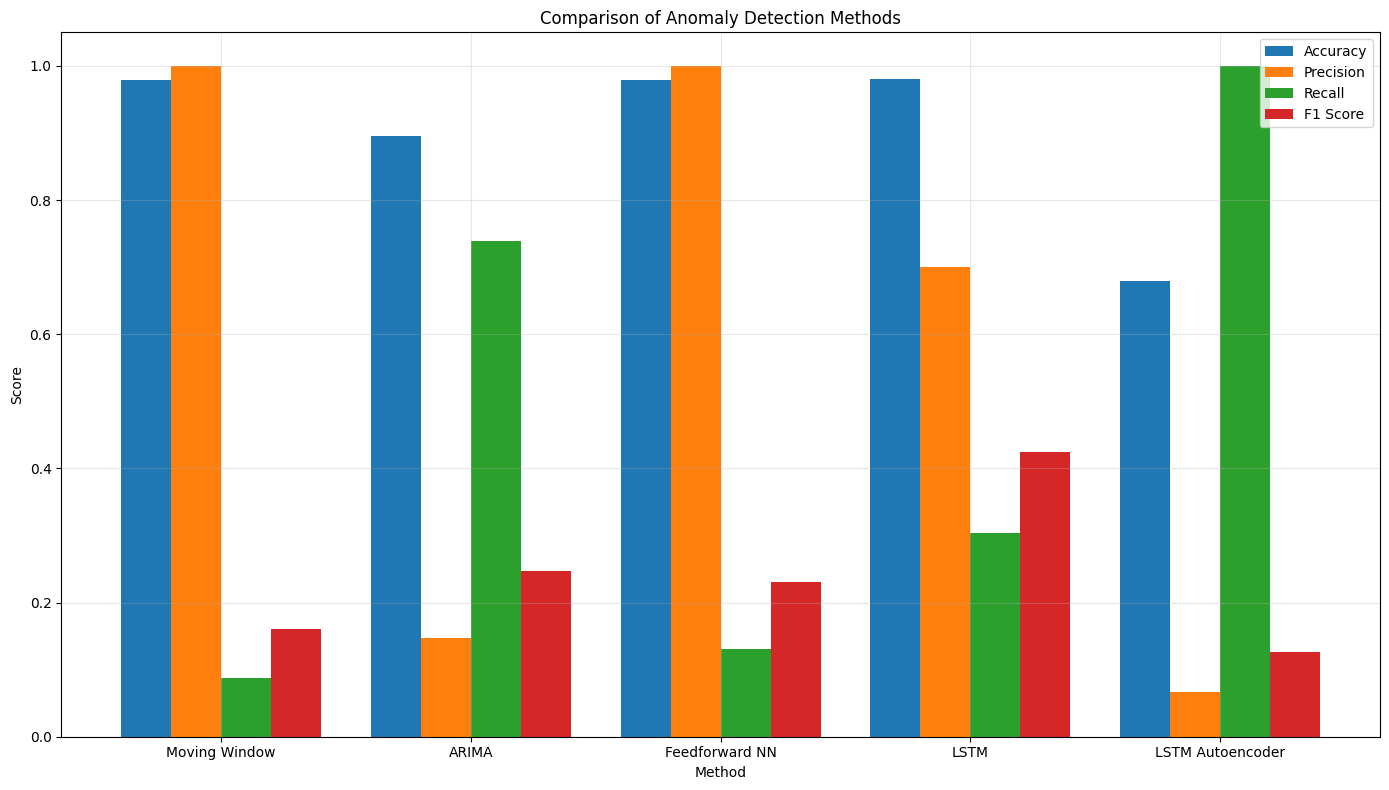

In [9]:
# Create a comparison DataFrame
methods = ['Moving Window', 'ARIMA', 'Feedforward NN', 'LSTM', 'LSTM Autoencoder']
metrics_df = pd.DataFrame({
    'Method': methods,
    'Accuracy': [mw_metrics['accuracy'], arima_metrics['accuracy'],
                ffnn_metrics['accuracy'], lstm_metrics['accuracy'], ae_metrics['accuracy']],
    'Precision': [mw_metrics['precision'], arima_metrics['precision'],
                 ffnn_metrics['precision'], lstm_metrics['precision'], ae_metrics['precision']],
    'Recall': [mw_metrics['recall'], arima_metrics['recall'],
               ffnn_metrics['recall'], lstm_metrics['recall'], ae_metrics['recall']],
    'F1 Score': [mw_metrics['f1'], arima_metrics['f1'],
                ffnn_metrics['f1'], lstm_metrics['f1'], ae_metrics['f1']]
})

# Display comparison table
print(metrics_df.to_string(index=False))

# Create bar chart comparison
plt.figure(figsize=(14, 8))

# Plot each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
width = 0.2
x = np.arange(len(methods))

for i, metric in enumerate(metrics):
    plt.bar(x + i*width - width*1.5, metrics_df[metric], width, label=metric)

plt.xlabel('Method')
plt.ylabel('Score')
plt.title('Comparison of Anomaly Detection Methods')
plt.xticks(x, methods)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Conclusion

In this notebook, we've explored a range of approaches for anomaly detection in time series data:

### Statistical Methods:
- **Moving Window**: Simple and interpretable, but less effective for complex patterns
- **ARIMA**: Captures time series dynamics, but requires parameter tuning and stationarity

### Neural Network Approaches:
- **Feedforward Neural Networks**: Can learn non-linear patterns using windowed data
- **Recurrent Neural Networks**: Designed for sequences, but suffer from vanishing gradients
- **LSTM**: Addresses the vanishing gradient problem with gate mechanisms
- **LSTM Autoencoders**: Unsupervised approach that learns normal patterns and detects deviations

### Key Insights:

1. **Context matters**: Different anomaly types require different detection approaches
2. **Trade-offs**: More complex models generally perform better but require more data and computational resources
3. **Interpretability**: Statistical methods provide clearer explanations but may miss subtle patterns
4. **Unsupervised learning**: LSTM autoencoders excel when labeled anomaly data is scarce

For real-world applications, consider:
- Combining multiple methods for robust detection
- Careful threshold selection based on domain knowledge
- Regular model retraining as normal patterns evolve over time
